# Tree Cutting Prioraty

For show the result in QGIS 

1. Click on (Run All) to run the code
2. Open QGIS
3. Go to Layer → Add Layer → Add Vector Layer
4. Browse to your file:
5. cutting_priority.shp
6. Click Add
7. Right-click the layer → Properties
8. Go to Symbology
9. Change Render type to Graduated
10. Column = priority
11. Choose a color scheme: YlOrRd, RdYlGn, or Spectral
12. Click Classify
13. Press Apply

## Import Libraries

These are all the Python libraries required for the GIS workflow.

In [44]:
import warnings; warnings.filterwarnings("ignore")
import os
import numpy              as np
import geopandas          as gpd
import matplotlib.pyplot  as plt
from   rasterstats        import zonal_stats
from   rasterio.features  import rasterize
from   rasterio.transform import from_origin
from   scipy.ndimage      import distance_transform_edt

## Load All Shapefiles

Load the data you have already stored in your data/ directory.

In [12]:
path          = "data"

trees         = gpd.read_file(f"{path}/SBNFMortalityt.shp")
community     = gpd.read_file(f"{path}/Communityfeatures.shp")
roads         = gpd.read_file(f"{path}/EgressRoutes.shp")
population    = gpd.read_file(f"{path}/PopulatedAreast.shp")
dist_circuits = gpd.read_file(f"{path}/DistCircuits.shp")
transmission  = gpd.read_file(f"{path}/Transmission.shp")
substations   = gpd.read_file(f"{path}/Substations.shp")
grid          = gpd.read_file(f"{path}/CuttingGrids.shp")
town_boundary = gpd.read_file(f"{path}/TownBoundary.shp")

## Reproject Layers Into a Projected CRS

We convert all layers into a projected CRS to allow distance calculations.

In [13]:
crs    = "EPSG:3857"
layers = [trees, community, roads, population, transmission, substations, grid, town_boundary]
layers = [l.to_crs(crs) for l in layers]


trees, community, roads, population, transmission, substations, grid, town_boundary = layers

## Create a Base Raster Grid

We prepare a raster canvas based on the town boundary.

In [15]:
resolution = 30

minx, miny, maxx, maxy = town_boundary.total_bounds

transform  = from_origin(minx, maxy, resolution, resolution)

## Define Feature-to-Raster Function

This converts polygons/lines into binary rasters.

In [16]:
width  = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)

def to_raster(gdf, value=1):
    shapes = [(geom, value) for geom in gdf.geometry]

    return rasterize(shapes, out_shape=(height, width), transform=transform, fill=0, dtype="int16")

## Rasterize All Input Feature Layers

This produces one raster mask for each criterion.

In [17]:
trees_r = to_raster(gdf=trees)
comm_r  = to_raster(gdf=community)
roads_r = to_raster(gdf=roads)
pop_r   = to_raster(gdf=population)
util_r  = ((to_raster(gdf=transmission) > 0) | (to_raster(gdf=substations) > 0)).astype(int)


## Compute Euclidean Distances for Each Raster

Euclidean distance is measured from every cell to the nearest feature.

In [18]:
def euclidean(binary_mask): return distance_transform_edt(binary_mask == 0) * resolution

dist_trees = euclidean(binary_mask=trees_r)
dist_comm  = euclidean(binary_mask=comm_r)
dist_roads = euclidean(binary_mask=roads_r)
dist_pop   = euclidean(binary_mask=pop_r)
dist_util  = euclidean(binary_mask=util_r)

## Reclassify Distance Rasters

We convert distance values into categories (1–5) for weighted overlay.

In [19]:
def reclass(dist):
    rc = np.zeros_like(dist, dtype=np.int16)

    rc[dist <= 100]                   = 5
    rc[(dist > 100) & (dist <= 300)]  = 4
    rc[(dist > 300) & (dist <= 600)]  = 3
    rc[(dist > 600) & (dist <= 1000)] = 2
    rc[dist > 1000]                   = 1

    return rc

rc_trees = reclass(dist=dist_trees)
rc_comm  = reclass(dist=dist_comm)
rc_roads = reclass(dist=dist_roads)
rc_pop   = reclass(dist=dist_pop)
rc_util  = reclass(dist=dist_util)

## Weighted Overlay to Compute Priority

Multiply each reclassified raster by its factor weight and sum.

In [21]:
weights         = {"trees": 10, "community": 15, "roads": 15, "population": 25, "utilities": 5}

priority_raster = rc_trees * weights["trees"] + rc_comm * weights["community"] + rc_roads * weights["roads"] + rc_pop * weights["population"] + rc_util * weights["utilities"]

## Zonal Statistics to Assign Priority to Each Grid Cell

We compute the mean priority per polygon in CuttingGrid.

In [22]:
zs = zonal_stats(grid, priority_raster, affine=transform, stats=["mean"], nodata=0)

grid["priority"] = [z["mean"] for z in zs]

## Visualize Priority Per Area

We make a map of the final tree-cutting priority.

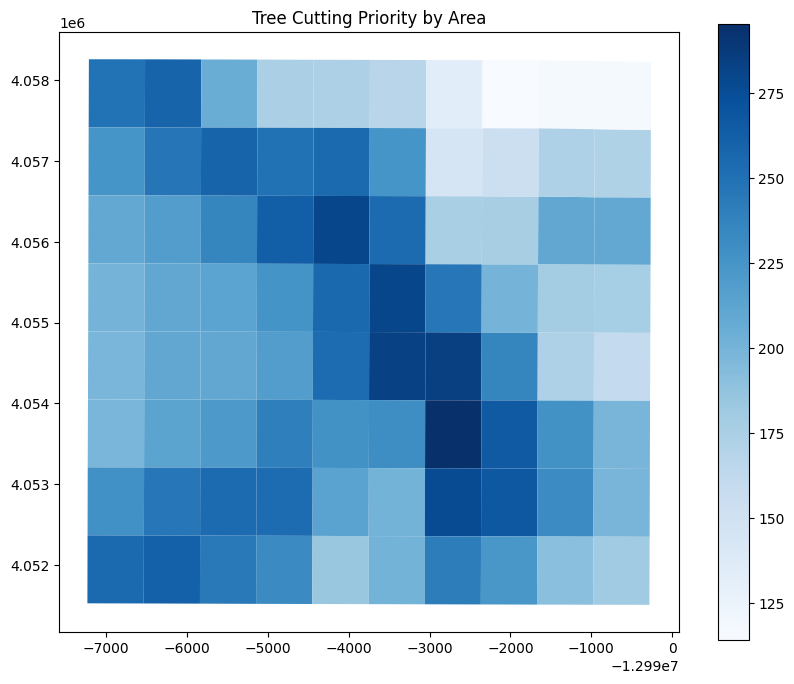

In [41]:
grid.plot(column="priority", cmap="Blues", legend=True, figsize=(10,8))

plt.title("Tree Cutting Priority by Area")
plt.show()

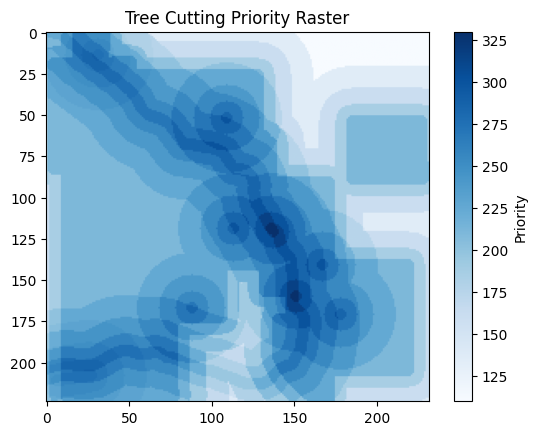

In [42]:
plt.imshow(priority_raster, cmap="Blues")
plt.colorbar(label="Priority")
plt.title("Tree Cutting Priority Raster")
plt.show()


## Save Result for QGIS

Export final shapefile with priority values.

In [45]:
os.makedirs(name="results", exist_ok=True)

grid.to_file("results/cutting_priority.shp")